In [ ]:
# Блокнот для анализа аномалий с использованием FEDOT
# Установка необходимых библиотек
#!pip install Fedot -U
#!pip install fedot[extra]
#!pip install torch

In [14]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
# Импорт необходимых модулей из FEDOT
from fedot.core.repository.tasks import Task, TaskTypesEnum
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.data.data import InputData
from fedot.api.main import Fedot

In [3]:
# Загрузка и подготовка данных

df_broken = pd.read_csv("processed_data_rotor_bar_broken_with_diffs_and_wavelets.csv")
df_healthy = pd.read_csv("processed_data_rotor_healthy_with_diffs_and_wavelets.csv")

# Объединяем оба датафрейма
df_combined = pd.concat([df_broken, df_healthy], ignore_index=True)

# Удаляем колонку 'measurement'
df_combined.drop(columns=['measurement'], inplace=True)

# Разделяем данные и метки
X = df_combined.drop(columns=['label'])
y = df_combined['label']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Уменьшение объема данных
X_train_small, _, y_train_small, _ = train_test_split(X_train, y_train, train_size=0.5, random_state=42)

# Выводим информацию о сформированных наборах
print(f"Размер обучающей выборки: {X_train_small.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")


Размер обучающей выборки: (816000, 90)
Размер тестовой выборки: (408000, 90)


In [ ]:
 # Преобразуем DataFrame в numpy массив перед передачей в FEDOT
X_train_np = X_train_small.values
X_test_np = X_test.values

# Создание объекта InputData для обучающей выборки
train_input = InputData(idx=np.arange(0, len(X_train_np)),
                        features=X_train_np,
                        target=y_train_small.values,  # Используем y_train_small
                        task=Task(TaskTypesEnum.classification),
                        data_type=DataTypesEnum.table)

# Создание объекта InputData для тестовой выборки
test_input = InputData(idx=np.arange(0, len(X_test_np)),
                       features=X_test_np,
                       target=y_test.values,
                       task=Task(TaskTypesEnum.classification),
                       data_type=DataTypesEnum.table)

# Настройка FEDOT с пресетом на максимальную производительность
pipeline = Fedot(problem='classification', preset='fast_train', timeout=1)

# Обучение модели на обучающей выборке
pipeline.fit(train_input)

Accuracy на тестовой выборке: 0.9113651960784314
F1-score на тестовой выборке: 0.8961027734465418
Precision на тестовой выборке: 0.9150646515248906
Recall на тестовой выборке: 0.9113651960784314
Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95    348000
           1       0.95      0.42      0.58     60000

    accuracy                           0.91    408000
   macro avg       0.93      0.71      0.77    408000
weighted avg       0.92      0.91      0.90    408000



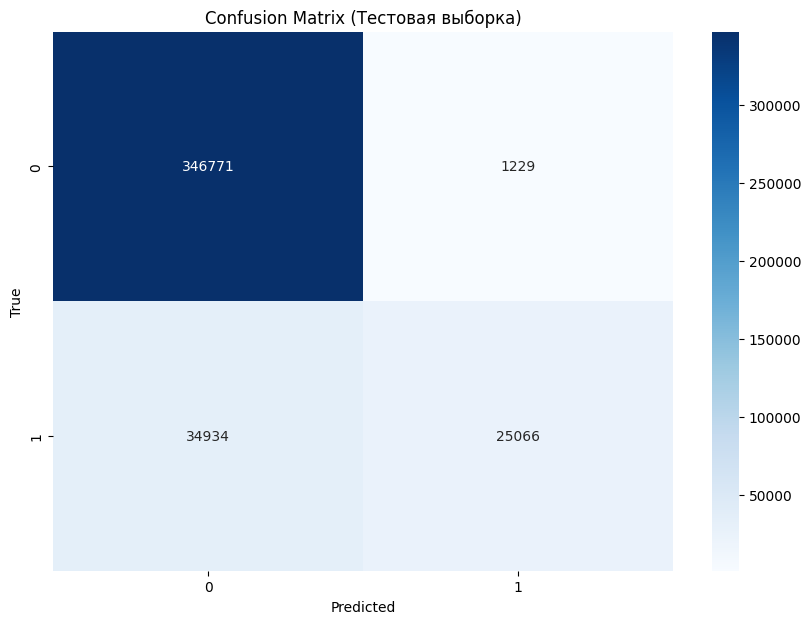

In [8]:
import numpy as np
import pandas as pd
from fedot.api.main import Fedot
from fedot.core.data.data import InputData
from fedot.core.data.data import Task, TaskTypesEnum, DataTypesEnum
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

# Предсказание на тестовой выборке
results = pipeline.predict(test_input)

# Преобразование результатов в понятный формат
y_pred = results

# Метрики на тестовой выборке
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
matrix = confusion_matrix(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f'Accuracy на тестовой выборке: {accuracy}')
print(f'F1-score на тестовой выборке: {f1}')
print(f'Precision на тестовой выборке: {precision}')
print(f'Recall на тестовой выборке: {recall}')
print('Classification Report:\n', report)

# Визуализация матрицы ошибок
plt.figure(figsize=(10, 7))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Тестовая выборка)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


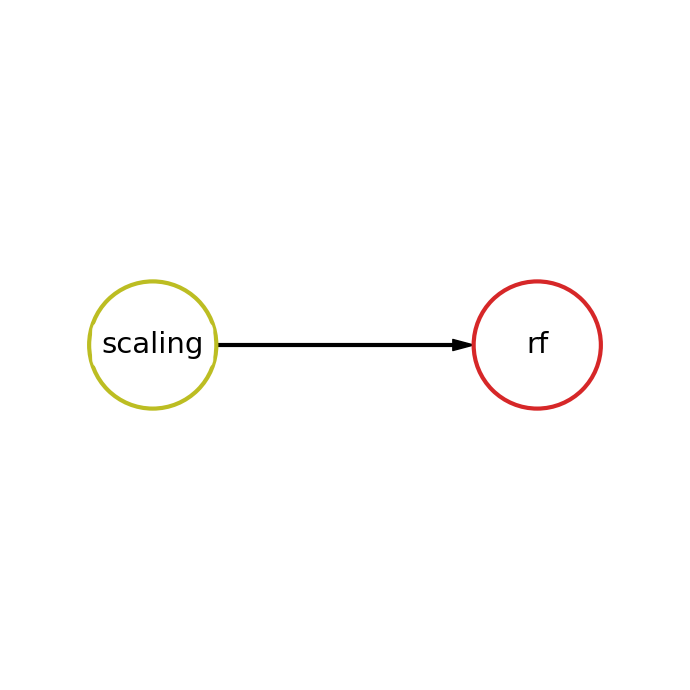

In [9]:
# Визуализация конфигурации пайплайна
pipeline.current_pipeline.show()

In [ ]:
# Сохранение обученной модели
pipeline.current_pipeline.save(path="fedot_pipeline_anomaly_detection (0 and broken) - fast")

# Сохранение предсказаний на тестовой выборке в CSV файл
output_path = "fedot_test_predictions (0 and broken - fast).csv"
pd.DataFrame({'True Labels': y_test.values, 'Predictions': y_pred.flatten()}).to_csv(output_path, index=False)
print(f"Результаты сохранены в {output_path}")